In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sqlite3 
conn = sqlite3.connect('im.db')

In [3]:

imdb_basics_df = pd.read_sql("""
SELECT * FROM movie_basics
;""",conn)
imdb_basics_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [4]:
tmdb_df = pd.read_csv('tmdb.movies.csv')
tmdb_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [5]:
bom_df = pd.read_csv('bom.movie_gross.csv')

In [6]:

bom_df.foreign_gross.str.replace(',', '').astype('float64')

0       652000000.0
1       691300000.0
2       664300000.0
3       535700000.0
4       513900000.0
           ...     
3382            NaN
3383            NaN
3384            NaN
3385            NaN
3386            NaN
Name: foreign_gross, Length: 3387, dtype: float64

In [7]:
budg_df = pd.read_csv('tn.movie_budgets.csv')
budg_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [8]:
info_df = pd.read_csv('rt.movie_info.tsv',delimiter='\t')
info_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [9]:
review_df = pd.read_csv('rt.reviews.tsv',delimiter='\t',encoding='windows-1252')
review_df

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [10]:
import string
punct_list = list(string.punctuation) + [" "]
len(punct_list)

33

In [11]:
og_list = imdb_basics_df.original_title.str.lower()
for char in punct_list:
    og_list = og_list.str.replace(char,"")
og_list
imdb_basics_df['og_name'] = og_list
imdb_basics_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\3168116866.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  og_list = og_list.str.replace(char,"")


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",ashadkaekdin
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,theothersideofthewind
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",sabsebadasukh
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",latelenovelaerrante
...,...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,kuambillagihatiku
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,rodolphoteóphiloolegadodeumpioneiro
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,dankyavardanka
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None,6gunn


In [12]:
prim_list = imdb_basics_df.primary_title.str.lower()
for char in punct_list:
    prim_list = prim_list.str.replace(char,"")
prim_list
imdb_basics_df['prim_name'] = prim_list
imdb_basics_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\196371986.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prim_list = prim_list.str.replace(char,"")


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name,prim_name
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh,sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",ashadkaekdin,onedaybeforetherainyseason
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,theothersideofthewind,theothersideofthewind
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",sabsebadasukh,sabsebadasukh
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",latelenovelaerrante,thewanderingsoapopera
...,...,...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,kuambillagihatiku,kuambillagihatiku
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,rodolphoteóphiloolegadodeumpioneiro,rodolphoteóphiloolegadodeumpioneiro
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,dankyavardanka,dankyavardanka
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None,6gunn,6gunn


In [13]:
budget_list = budg_df.movie.str.lower()
for char in punct_list:
    budget_list = budget_list.str.replace(char,"")
budget_list
budg_df['key_name'] = budget_list
budg_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\3876272036.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budget_list = budget_list.str.replace(char,"")


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",piratesofthecaribbeanonstrangertides
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",darkphoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengersageofultron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",starwarsepviiithelastjedi
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,red11
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",following
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",returntothelandofwonders
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,aplaguesopleasant


In [14]:
for i,v in enumerate(list(imdb_basics_df.prim_name.values)):
    x = imdb_basics_df.og_name.values[i]

In [15]:
key_titles = []
target = list(budget_list)
for i,v in enumerate(list(imdb_basics_df.prim_name.values)):
    x = imdb_basics_df.og_name.values[i]
    if v in target:
        key_titles.append(v)
    elif x in target:
        key_titles.append(x)
    else: key_titles.append(np.NaN)
imdb_basics_df['key_title'] = key_titles
len(list(set(key_titles)))

2488

In [16]:
imdb_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   og_name          146123 non-null  object 
 7   prim_name        146144 non-null  object 
 8   key_title        3932 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 10.0+ MB


In [17]:

imdb_basics_df.drop_duplicates(subset = 'key_title', inplace = True)

In [18]:
imdb_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2488 entries, 0 to 145986
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         2488 non-null   object 
 1   primary_title    2488 non-null   object 
 2   original_title   2488 non-null   object 
 3   start_year       2488 non-null   int64  
 4   runtime_minutes  2303 non-null   float64
 5   genres           2461 non-null   object 
 6   og_name          2488 non-null   object 
 7   prim_name        2488 non-null   object 
 8   key_title        2487 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 194.4+ KB


In [19]:
budg_df.drop_duplicates(subset = 'key_name', inplace = True)

In [20]:
merged_df = pd.merge(how='inner',left = imdb_basics_df,right = budg_df,left_on = imdb_basics_df.key_title,right_on=budg_df.key_name)

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2487 entries, 0 to 2486
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_0              2487 non-null   object 
 1   movie_id           2487 non-null   object 
 2   primary_title      2487 non-null   object 
 3   original_title     2487 non-null   object 
 4   start_year         2487 non-null   int64  
 5   runtime_minutes    2302 non-null   float64
 6   genres             2460 non-null   object 
 7   og_name            2487 non-null   object 
 8   prim_name          2487 non-null   object 
 9   key_title          2487 non-null   object 
 10  id                 2487 non-null   int64  
 11  release_date       2487 non-null   object 
 12  movie              2487 non-null   object 
 13  production_budget  2487 non-null   object 
 14  domestic_gross     2487 non-null   object 
 15  worldwide_gross    2487 non-null   object 
 16  key_name           2487 

In [22]:
objects_to_floats = ['production_budget','domestic_gross','worldwide_gross']

for x in objects_to_floats:
    merged_df[x] = merged_df[x].str.replace('$',"")
    merged_df[x] = merged_df[x].str.replace(',',"")
    merged_df[x] = merged_df[x].astype('float64')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2487 entries, 0 to 2486
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_0              2487 non-null   object 
 1   movie_id           2487 non-null   object 
 2   primary_title      2487 non-null   object 
 3   original_title     2487 non-null   object 
 4   start_year         2487 non-null   int64  
 5   runtime_minutes    2302 non-null   float64
 6   genres             2460 non-null   object 
 7   og_name            2487 non-null   object 
 8   prim_name          2487 non-null   object 
 9   key_title          2487 non-null   object 
 10  id                 2487 non-null   int64  
 11  release_date       2487 non-null   object 
 12  movie              2487 non-null   object 
 13  production_budget  2487 non-null   float64
 14  domestic_gross     2487 non-null   float64
 15  worldwide_gross    2487 non-null   float64
 16  key_name           2487 

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\2623435804.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df[x] = merged_df[x].str.replace('$',"")


In [23]:
merged_df['Profitability'] = merged_df.worldwide_gross - merged_df.production_budget
merged_df

,key_0,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name,prim_name,key_title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name,Profitability
0,foodfight,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",foodfight,foodfight,foodfight,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,foodfight,-44926294.0
1,mortalkombat,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",mortalkombat,mortalkombat,mortalkombat,10,"Aug 18, 1995",Mortal Kombat,20000000.0,70433227.0,122133227.0,mortalkombat,102133227.0
2,theovernight,tt0326592,The Overnight,The Overnight,2010,88.0,None,theovernight,theovernight,theovernight,21,"Jun 19, 2015",The Overnight,200000.0,1109808.0,1165996.0,theovernight,965996.0
3,ontheroad,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",ontheroad,ontheroad,ontheroad,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,ontheroad,-15686698.0
4,thesecretlifeofwaltermitty,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,thesecretlifeofwaltermitty,96861183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,fuel,tt9678962,Fuel,Fuel,2018,NaN,"Documentary,Sport",fuel,fuel,fuel,35,"Nov 14, 2008",Fuel,2500000.0,174255.0,174255.0,fuel,-2325745.0
2483,diner,tt9729206,Diner,Diner,2019,NaN,Crime,diner,diner,diner,11,"Apr 2, 1982",Diner,5000000.0,12592907.0,12592907.0,diner,7592907.0
2484,traitor,tt9805168,Traitor,Traitor,2015,110.0,"Action,Drama,Romance",traitor,traitor,traitor,25,"Aug 27, 2008",Traitor,22000000.0,23530831.0,27882226.0,traitor,5882226.0
2485,kisskissbangbang,tt9889814,Kiss Kiss Bang Bang,Kiss Kiss Bang Bang,2017,98.0,"Crime,Romance,Thriller",kisskissbangbang,kisskissbangbang,kisskissbangbang,23,"Oct 21, 2005","Kiss Kiss, Bang Bang",15000000.0,4235837.0,16829464.0,kisskissbangbang,1829464.0


In [24]:
genres = []
genre_list = list(merged_df.genres.value_counts().keys())
for x in genre_list:
    row_genres = []
    for y in x.split(','):
        genres.append(y)
genres = list(set(genres))
print(genres)

['Sport', 'Adventure', 'Sci-Fi', 'Mystery', 'Drama', 'Western', 'Animation', 'Biography', 'History', 'Documentary', 'Musical', 'Romance', 'Music', 'Thriller', 'Horror', 'Action', 'War', 'Fantasy', 'Crime', 'News', 'Family', 'Comedy']


In [25]:
for i,x in enumerate(merged_df.genres):
    genres_ = []
    if x is not None:
        for y in x.split(","):
            genres_.append(y)
        merged_df['genres'][i] = genres_
merged_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\605833973.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['genres'][i] = genres_


,key_0,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name,prim_name,key_title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name,Profitability
0,foodfight,tt0249516,Foodfight!,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",foodfight,foodfight,foodfight,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,foodfight,-44926294.0
1,mortalkombat,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"[Action, Adventure, Fantasy]",mortalkombat,mortalkombat,mortalkombat,10,"Aug 18, 1995",Mortal Kombat,20000000.0,70433227.0,122133227.0,mortalkombat,102133227.0
2,theovernight,tt0326592,The Overnight,The Overnight,2010,88.0,None,theovernight,theovernight,theovernight,21,"Jun 19, 2015",The Overnight,200000.0,1109808.0,1165996.0,theovernight,965996.0
3,ontheroad,tt0337692,On the Road,On the Road,2012,124.0,"[Adventure, Drama, Romance]",ontheroad,ontheroad,ontheroad,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,ontheroad,-15686698.0
4,thesecretlifeofwaltermitty,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"[Adventure, Comedy, Drama]",thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,thesecretlifeofwaltermitty,96861183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,fuel,tt9678962,Fuel,Fuel,2018,NaN,"[Documentary, Sport]",fuel,fuel,fuel,35,"Nov 14, 2008",Fuel,2500000.0,174255.0,174255.0,fuel,-2325745.0
2483,diner,tt9729206,Diner,Diner,2019,NaN,[Crime],diner,diner,diner,11,"Apr 2, 1982",Diner,5000000.0,12592907.0,12592907.0,diner,7592907.0
2484,traitor,tt9805168,Traitor,Traitor,2015,110.0,"[Action, Drama, Romance]",traitor,traitor,traitor,25,"Aug 27, 2008",Traitor,22000000.0,23530831.0,27882226.0,traitor,5882226.0
2485,kisskissbangbang,tt9889814,Kiss Kiss Bang Bang,Kiss Kiss Bang Bang,2017,98.0,"[Crime, Romance, Thriller]",kisskissbangbang,kisskissbangbang,kisskissbangbang,23,"Oct 21, 2005","Kiss Kiss, Bang Bang",15000000.0,4235837.0,16829464.0,kisskissbangbang,1829464.0


In [26]:
genres

['Sport',
 'Adventure',
 'Sci-Fi',
 'Mystery',
 'Drama',
 'Western',
 'Animation',
 'Biography',
 'History',
 'Documentary',
 'Musical',
 'Romance',
 'Music',
 'Thriller',
 'Horror',
 'Action',
 'War',
 'Fantasy',
 'Crime',
 'News',
 'Family',
 'Comedy']

In [27]:

for genre in genres:        #genre is one of the unique genres from the list
    merged_df[genre] = 0
    for ind, value in enumerate(merged_df['genres']): # index is the index of the row - row is 
        if (value is not None):
            if (genre in value):
                merged_df[genre][ind]=1
merged_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\2257749477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[genre][ind]=1
C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\2257749477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[genre][ind]=1
C:\Users\kapta\AppData\Local\Temp\ipykernel_27436\2257749477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[genre][ind]=1
C:\Users\kapta\AppData\Local

,key_0,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name,prim_name,key_title,...,Music,Thriller,Horror,Action,War,Fantasy,Crime,News,Family,Comedy
0,foodfight,tt0249516,Foodfight!,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",foodfight,foodfight,foodfight,...,0,0,0,1,0,0,0,0,0,1
1,mortalkombat,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"[Action, Adventure, Fantasy]",mortalkombat,mortalkombat,mortalkombat,...,0,0,0,1,0,1,0,0,0,0
2,theovernight,tt0326592,The Overnight,The Overnight,2010,88.0,None,theovernight,theovernight,theovernight,...,0,0,0,0,0,0,0,0,0,0
3,ontheroad,tt0337692,On the Road,On the Road,2012,124.0,"[Adventure, Drama, Romance]",ontheroad,ontheroad,ontheroad,...,0,0,0,0,0,0,0,0,0,0
4,thesecretlifeofwaltermitty,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"[Adventure, Comedy, Drama]",thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,fuel,tt9678962,Fuel,Fuel,2018,NaN,"[Documentary, Sport]",fuel,fuel,fuel,...,0,0,0,0,0,0,0,0,0,0
2483,diner,tt9729206,Diner,Diner,2019,NaN,[Crime],diner,diner,diner,...,0,0,0,0,0,0,1,0,0,0
2484,traitor,tt9805168,Traitor,Traitor,2015,110.0,"[Action, Drama, Romance]",traitor,traitor,traitor,...,0,0,0,1,0,0,0,0,0,0
2485,kisskissbangbang,tt9889814,Kiss Kiss Bang Bang,Kiss Kiss Bang Bang,2017,98.0,"[Crime, Romance, Thriller]",kisskissbangbang,kisskissbangbang,kisskissbangbang,...,0,1,0,0,0,0,1,0,0,0


In [28]:
merged_df.T.unstack()

0     key_0              foodfight
      movie_id           tt0249516
      primary_title     Foodfight!
      original_title    Foodfight!
      start_year              2012
                           ...    
2486  Fantasy                    0
      Crime                      0
      News                       0
      Family                     0
      Comedy                     0
Length: 99480, dtype: object

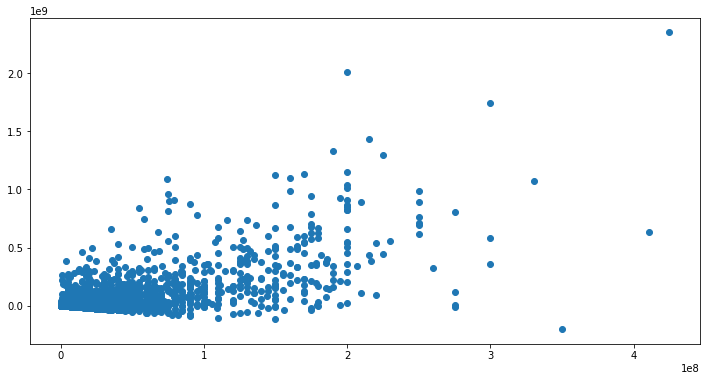

In [29]:
x=merged_df.production_budget
y=merged_df.Profitability
fig,ax = plt.subplots(figsize = (12,6))
ax.scatter(x,y)

In [30]:
merged_df['ROI_ratio'] = merged_df.Profitability / merged_df.production_budget

In [31]:
dfb = pd.DataFrame(merged_df.production_budget)
for i,x in enumerate(genres):
    dfb[x] = merged_df[x] * merged_df.production_budget
dfb

,production_budget,Sport,Adventure,Sci-Fi,Mystery,Drama,Western,Animation,Biography,History,...,Music,Thriller,Horror,Action,War,Fantasy,Crime,News,Family,Comedy
0,45000000.0,0.0,0.0,0.0,0.0,0.0,0.0,45000000.0,0.0,0.0,...,0.0,0.0,0.0,45000000.0,0.0,0.0,0.0,0.0,0.0,45000000.0
1,20000000.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20000000.0,0.0,20000000.0,0.0,0.0,0.0,0.0
2,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25000000.0,0.0,25000000.0,0.0,0.0,25000000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91000000.0,0.0,91000000.0,0.0,0.0,91000000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,2500000.0,2500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2483,5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0,0.0,0.0
2484,22000000.0,0.0,0.0,0.0,0.0,22000000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22000000.0,0.0,0.0,0.0,0.0,0.0,0.0
2485,15000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15000000.0,0.0,0.0,0.0,0.0,15000000.0,0.0,0.0,0.0


In [33]:
dfp = pd.DataFrame(merged_df.Profitability)
for i,x in enumerate(genres):
    dfp[x] = merged_df[x] * merged_df.Profitability
dfp

,Profitability,Sport,Adventure,Sci-Fi,Mystery,Drama,Western,Animation,Biography,History,...,Music,Thriller,Horror,Action,War,Fantasy,Crime,News,Family,Comedy
0,-44926294.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-44926294.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-44926294.0,-0.0,-0.0,-0.0,-0.0,-0.0,-44926294.0
1,102133227.0,0.0,102133227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,102133227.0,0.0,102133227.0,0.0,0.0,0.0,0.0
2,965996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-15686698.0,-0.0,-15686698.0,-0.0,-0.0,-15686698.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,96861183.0,0.0,96861183.0,0.0,0.0,96861183.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96861183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,-2325745.0,-2325745.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2483,7592907.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7592907.0,0.0,0.0,0.0
2484,5882226.0,0.0,0.0,0.0,0.0,5882226.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5882226.0,0.0,0.0,0.0,0.0,0.0,0.0
2485,1829464.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1829464.0,0.0,0.0,0.0,0.0,1829464.0,0.0,0.0,0.0


In [34]:
col_names = list(dfp.columns)[1:]

Text(0.5, 1.0, 'Average ROI by Genre')

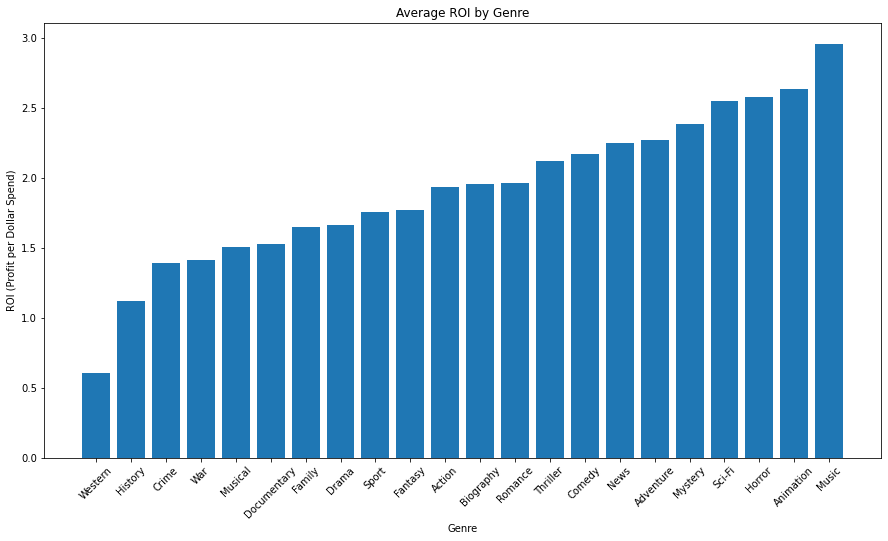

In [62]:
profits = dfp.sum(axis=0)[1:]
costs = dfb.sum(axis=0)[1:]

vals = pd.Series(profits.values / costs.values)

df_chart = pd.DataFrame(genres,columns=['genres'])
df_chart['average_ROI'] = vals
df_chart = df_chart.sort_values(by = 'average_ROI')
x =  df_chart.genres
y = df_chart.average_ROI
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (Profit per Dollar Spend)')
ax.set_title('Average ROI by Genre')

In [61]:
profits

Sport          8.090386e+05
Adventure      3.723339e+07
Sci-Fi         1.380233e+07
Mystery        3.792124e+06
Drama          1.914205e+07
Western        2.019434e+05
Animation      1.169392e+07
Biography      3.386828e+06
History        8.152325e+05
Documentary    2.191893e+06
Musical        3.472975e+05
Romance        4.720602e+06
Music          1.362466e+06
Thriller       9.257612e+06
Horror         5.139942e+06
Action         3.090687e+07
War            5.180030e+05
Fantasy        8.621528e+06
Crime          5.010298e+06
News           2.896017e+04
Family         4.768487e+06
Comedy         2.152954e+07
dtype: float64

Text(0.5, 1.0, 'Average Profitability by Genre')

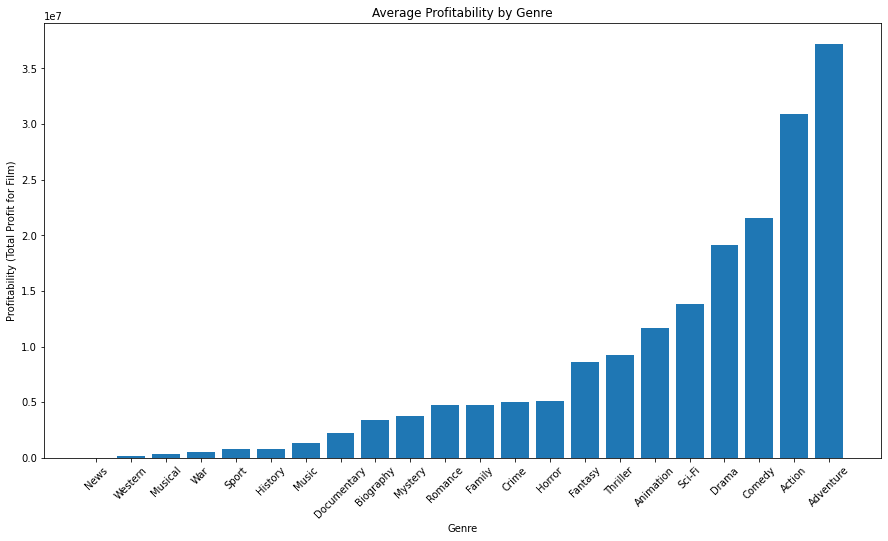

In [36]:
vals = dfp.mean(axis=0)[1:].sort_values()

x = vals.keys()
y = vals.values
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Profitability (Total Profit for Film)')
ax.set_title('Average Profitability by Genre')

In [63]:
merged_df['number_of_genres'] = merged_df.genres.str.len()
merged_df

,key_0,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,og_name,prim_name,key_title,...,Horror,Action,War,Fantasy,Crime,News,Family,Comedy,ROI_ratio,number_of_genres
0,foodfight,tt0249516,Foodfight!,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",foodfight,foodfight,foodfight,...,0,1,0,0,0,0,0,1,-0.998362,3.0
1,mortalkombat,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"[Action, Adventure, Fantasy]",mortalkombat,mortalkombat,mortalkombat,...,0,1,0,1,0,0,0,0,5.106661,3.0
2,theovernight,tt0326592,The Overnight,The Overnight,2010,88.0,None,theovernight,theovernight,theovernight,...,0,0,0,0,0,0,0,0,4.829980,NaN
3,ontheroad,tt0337692,On the Road,On the Road,2012,124.0,"[Adventure, Drama, Romance]",ontheroad,ontheroad,ontheroad,...,0,0,0,0,0,0,0,0,-0.627468,3.0
4,thesecretlifeofwaltermitty,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"[Adventure, Comedy, Drama]",thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,thesecretlifeofwaltermitty,...,0,0,0,0,0,0,0,1,1.064409,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,fuel,tt9678962,Fuel,Fuel,2018,NaN,"[Documentary, Sport]",fuel,fuel,fuel,...,0,0,0,0,0,0,0,0,-0.930298,2.0
2483,diner,tt9729206,Diner,Diner,2019,NaN,[Crime],diner,diner,diner,...,0,0,0,0,1,0,0,0,1.518581,1.0
2484,traitor,tt9805168,Traitor,Traitor,2015,110.0,"[Action, Drama, Romance]",traitor,traitor,traitor,...,0,1,0,0,0,0,0,0,0.267374,3.0
2485,kisskissbangbang,tt9889814,Kiss Kiss Bang Bang,Kiss Kiss Bang Bang,2017,98.0,"[Crime, Romance, Thriller]",kisskissbangbang,kisskissbangbang,kisskissbangbang,...,0,0,0,0,1,0,0,0,0.121964,3.0


,start_year,runtime_minutes,id,production_budget,domestic_gross,worldwide_gross,Profitability,Sport,Adventure,Sci-Fi,...,Thriller,Horror,Action,War,Fantasy,Crime,News,Family,Comedy,ROI_ratio
number_of_genres,,,,,,,,,,,,,,,,,,,,,
1.0,1123818,41219.0,27650,1.202250e+10,1.611287e+10,3.245158e+10,2.042908e+10,2,5,5,...,31,47,21,3,3,5,0,7,93,1092.667924
2.0,1167863,56363.0,30172,1.260431e+10,1.766324e+10,3.574142e+10,2.313712e+10,13,29,18,...,123,65,54,11,12,52,1,34,192,1645.697751
3.0,2662224,136780.0,66565,6.315542e+10,7.489304e+10,1.945184e+11,1.313630e+11,35,405,159,...,245,180,497,24,145,261,1,104,430,3666.095656


Text(0.5, 1.0, 'Average Profitability by Number of Genres')

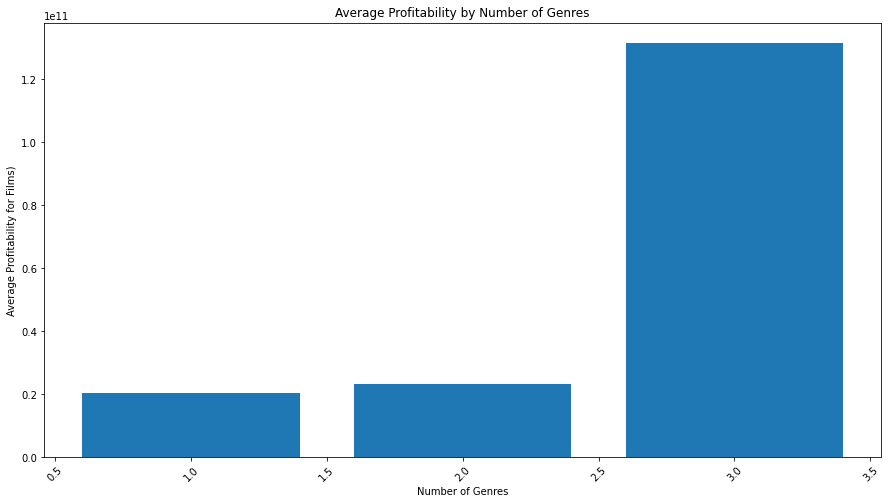

In [82]:
chart_data = merged_df.groupby('number_of_genres').sum()

x = chart_data.index
y = chart_data['Profitability']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Average Profitability for Films)')
ax.set_title('Average Profitability by Number of Genres')

Text(0.5, 1.0, 'Average ROI by Number of Genres')

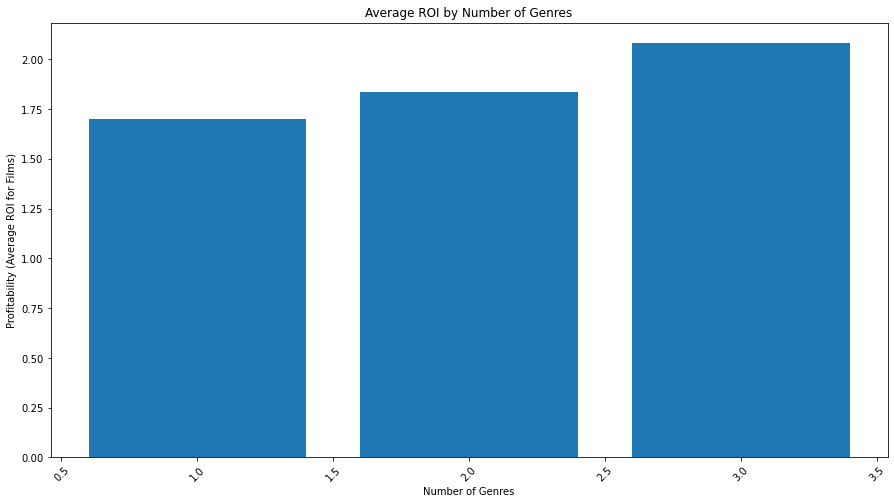

In [80]:
x = chart_data.index
y = chart_data['Profitability']/chart_data['production_budget']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Profitability (Average ROI for Films)')
ax.set_title('Average ROI by Number of Genres')

In [79]:
chart_data.index

Float64Index([1.0, 2.0, 3.0], dtype='float64', name='number_of_genres')